In [1]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions

## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "ieee-fraud-detection")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1          ✔ purrr   0.3.2     
✔ tibble  2.1.3          ✔ dplyr   0.8.3     
✔ tidyr   1.0.0.9000     ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "sample_submission.csv" "test_identity.csv"     "test_transaction.csv" 
[4] "train_identity.csv"    "train_transaction.csv"

In [3]:
filepath = "ieee-fraud-detection"
train_identity = read.csv(file.path(filepath, "train_identity.csv"))

In [4]:
train_transaction = read.csv(file.path(filepath, "train_transaction.csv"))
test_identity = read.csv(file.path(filepath, "test_identity.csv"))
test_transaction = read.csv(file.path(filepath, "test_transaction.csv"))

In [5]:
head(train_identity)

TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,⋯,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<dbl>,<fct>,<fct>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<fct>
2987004,0,70787,NA,NA,NA,NA,NA,NA,NA,⋯,samsung browser 6.2,32,2220x1080,match_status:2,TRUE,FALSE,TRUE,TRUE,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5,98945,NA,NA,0,-5,NA,NA,NA,⋯,mobile safari 11.0,32,1334x750,match_status:1,TRUE,FALSE,FALSE,TRUE,mobile,iOS Device
2987010,-5,191631,0,0,0,0,NA,NA,0,⋯,chrome 62.0,NA,,,FALSE,FALSE,TRUE,TRUE,desktop,Windows
2987011,-5,221832,NA,NA,0,-6,NA,NA,NA,⋯,chrome 62.0,NA,,,FALSE,FALSE,TRUE,TRUE,desktop,
2987016,0,7460,0,0,1,0,NA,NA,0,⋯,chrome 62.0,24,1280x800,match_status:2,TRUE,FALSE,TRUE,TRUE,desktop,MacOS
2987017,-5,61141,3,0,3,0,NA,NA,3,⋯,chrome 62.0,24,1366x768,match_status:2,TRUE,FALSE,TRUE,TRUE,desktop,Windows


In [6]:
head(train_transaction)

TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,⋯,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
<int>,<int>,<int>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2987000,0,86400,68.5,W,13926,NA,150,discover,142,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987001,0,86401,29.0,W,2755,404,150,mastercard,102,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987002,0,86469,59.0,W,4663,490,150,visa,166,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987003,0,86499,50.0,W,18132,567,150,mastercard,117,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2987004,0,86506,50.0,H,4497,514,150,mastercard,102,⋯,0,0,0,0,0,0,0,0,0,0
2987005,0,86510,49.0,W,5937,555,150,visa,226,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [33]:
print(paste("Train identity shape: ", paste(dim(train_identity), collapse = ", ")))
print(paste("Train transaction shape: ", paste(dim(train_transaction), collapse = ", ")))
print(paste("Test identity shape: ", paste(dim(test_identity), collapse = ", ")))
print(paste("Test transaction shape: ", paste(dim(test_transaction), collapse = ", ")))

[1] "Train identity shape:  144233, 41"
[1] "Train transaction shape:  590540, 394"
[1] "Test identity shape:  141907, 41"
[1] "Test transaction shape:  506691, 393"


Datasets for train and test are more or less the same size which makes it less likely that we'll overfit. We should check distributions for train/test to make sure they're the same

First, let's join the identity and transaction dataframes

In [12]:
train = left_join(train_transaction, train_identity)
test = left_join(test_transaction, test_identity)

Joining, by = "TransactionID"

Joining, by = "TransactionID"



In [23]:
is_fraud_prop <- prop.table(table(train['isFraud']))
is_fraud_prop


         0          1 
0.96500999 0.03499001 

We have a clear class imbalance that we should deal with somehow

In [35]:
# bind the two datasets together to make plotting easier
train$key <- "train"
test$key <- "test"
full <- bind_rows(train, test)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Wa

In [36]:
is_fraud <- data.frame(table(train['isFraud']))
colnames(is_fraud) <- c("is_fraud", "freq")

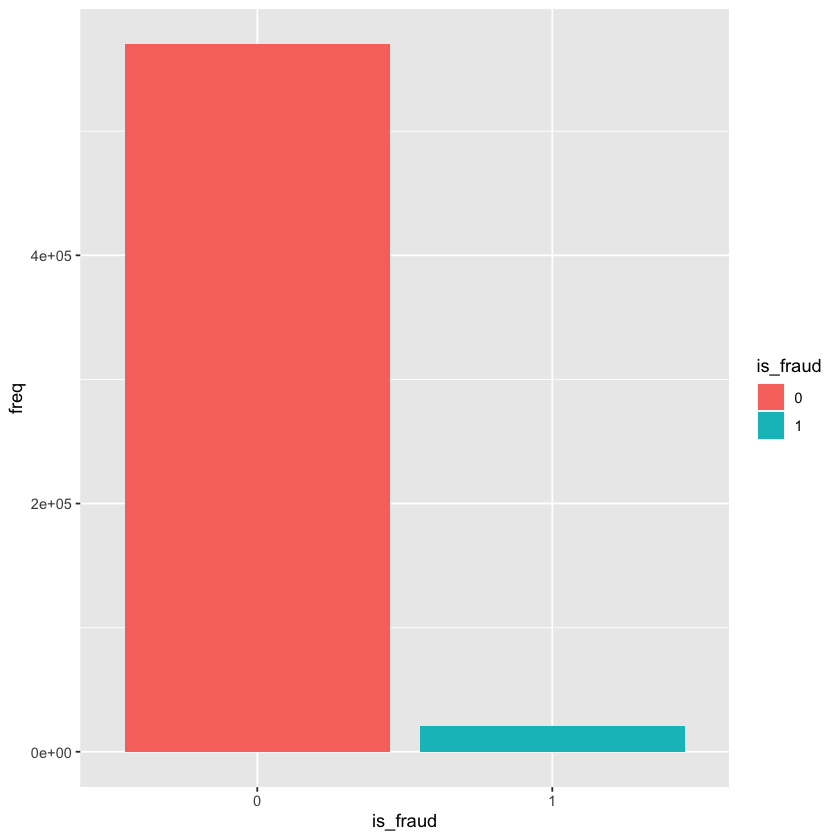

In [37]:
is_fraud  %>% 
    ggplot(aes(x = is_fraud, y = freq, fill = is_fraud)) + 
    geom_bar(stat = "identity")

In [41]:
library(ggthemes)

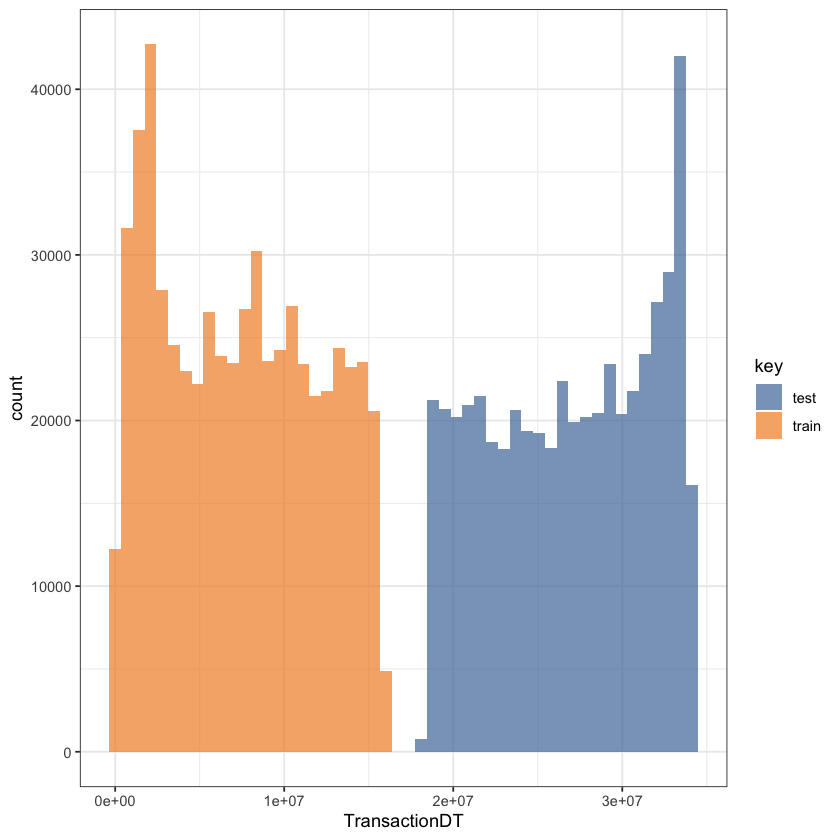

In [46]:
full %>% ggplot(aes(x= TransactionDT, fill=key)) + 
    geom_histogram(alpha = 0.7, bins=50) +
    scale_fill_tableau() +
    theme_bw()

In [50]:
library(grid)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [54]:
options(repr.plot.width=16, repr.plot.height=12) # resize plot option

In [57]:
colnames(full)

[1] "TransactionID"  "isFraud"        "TransactionDT"  "TransactionAmt"
  [5] "ProductCD"      "card1"          "card2"          "card3"         
  [9] "card4"          "card5"          "card6"          "addr1"         
 [13] "addr2"          "dist1"          "dist2"          "P_emaildomain" 
 [17] "R_emaildomain"  "C1"             "C2"             "C3"            
 [21] "C4"             "C5"             "C6"             "C7"            
 [25] "C8"             "C9"             "C10"            "C11"           
 [29] "C12"            "C13"            "C14"            "D1"            
 [33] "D2"             "D3"             "D4"             "D5"            
 [37] "D6"             "D7"             "D8"             "D9"            
 [41] "D10"            "D11"            "D12"            "D13"           
 [45] "D14"            "D15"            "M1"             "M2"            
 [49] "M3"             "M4"             "M5"             "M6"            
 [53] "M7"             "M8"             "M9"             "V1"            
 [57] "V2"             "V3"             "V4"             "V5"            
 [61] "V6"             "V7"             "V8"             "V9"            
 [65] "V10"            "V11"            "V12"            "V13"           
 [69] "V14"            "V15"            "V16"            "V17"           
 [73] "V18"            "V19"            "V20"            "V21"           
 [77] "V22"            "V23"            "V24"            "V25"           
 [81] "V26"            "V27"            "V28"            "V29"           
 [85] "V30"            "V31"            "V32"            "V33"           
 [89] "V34"            "V35"            "V36"            "V37"           
 [93] "V38"            "V39"            "V40"            "V41"           
 [97] "V42"            "V43"            "V44"            "V45"           
[101] "V46"            "V47"            "V48"            "V49"           
[105] "V50"            "V51"            "V52"            "V53"           
[109] "V54"            "V55"            "V56"            "V57"           
[113] "V58"            "V59"            "V60"            "V61"           
[117] "V62"            "V63"            "V64"            "V65"           
[121] "V66"            "V67"            "V68"            "V69"           
[125] "V70"            "V71"            "V72"            "V73"           
[129] "V74"            "V75"            "V76"            "V77"           
[133] "V78"            "V79"            "V80"            "V81"           
[137] "V82"            "V83"            "V84"            "V85"           
[141] "V86"            "V87"            "V88"            "V89"           
[145] "V90"            "V91"            "V92"            "V93"           
[149] "V94"            "V95"            "V96"            "V97"           
[153] "V98"            "V99"            "V100"           "V101"          
[157] "V102"           "V103"           "V104"           "V105"          
[161] "V106"           "V107"           "V108"           "V109"          
[165] "V110"           "V111"           "V112"           "V113"          
[169] "V114"           "V115"           "V116"           "V117"          
[173] "V118"           "V119"           "V120"           "V121"          
[177] "V122"           "V123"           "V124"           "V125"          
[181] "V126"           "V127"           "V128"           "V129"          
[185] "V130"           "V131"           "V132"           "V133"          
[189] "V134"           "V135"           "V136"           "V137"          
[193] "V138"           "V139"           "V140"           "V141"          
[197] "V142"           "V143"           "V144"           "V145"          
[201] "V146"           "V147"           "V148"           "V149"          
[205] "V150"           "V151"           "V152"           "V153"          
[209] "V154"           "V155"           "V156"           "V157"          
[213] "V158"           "V159"           "V160"           "V161"          
[217] 

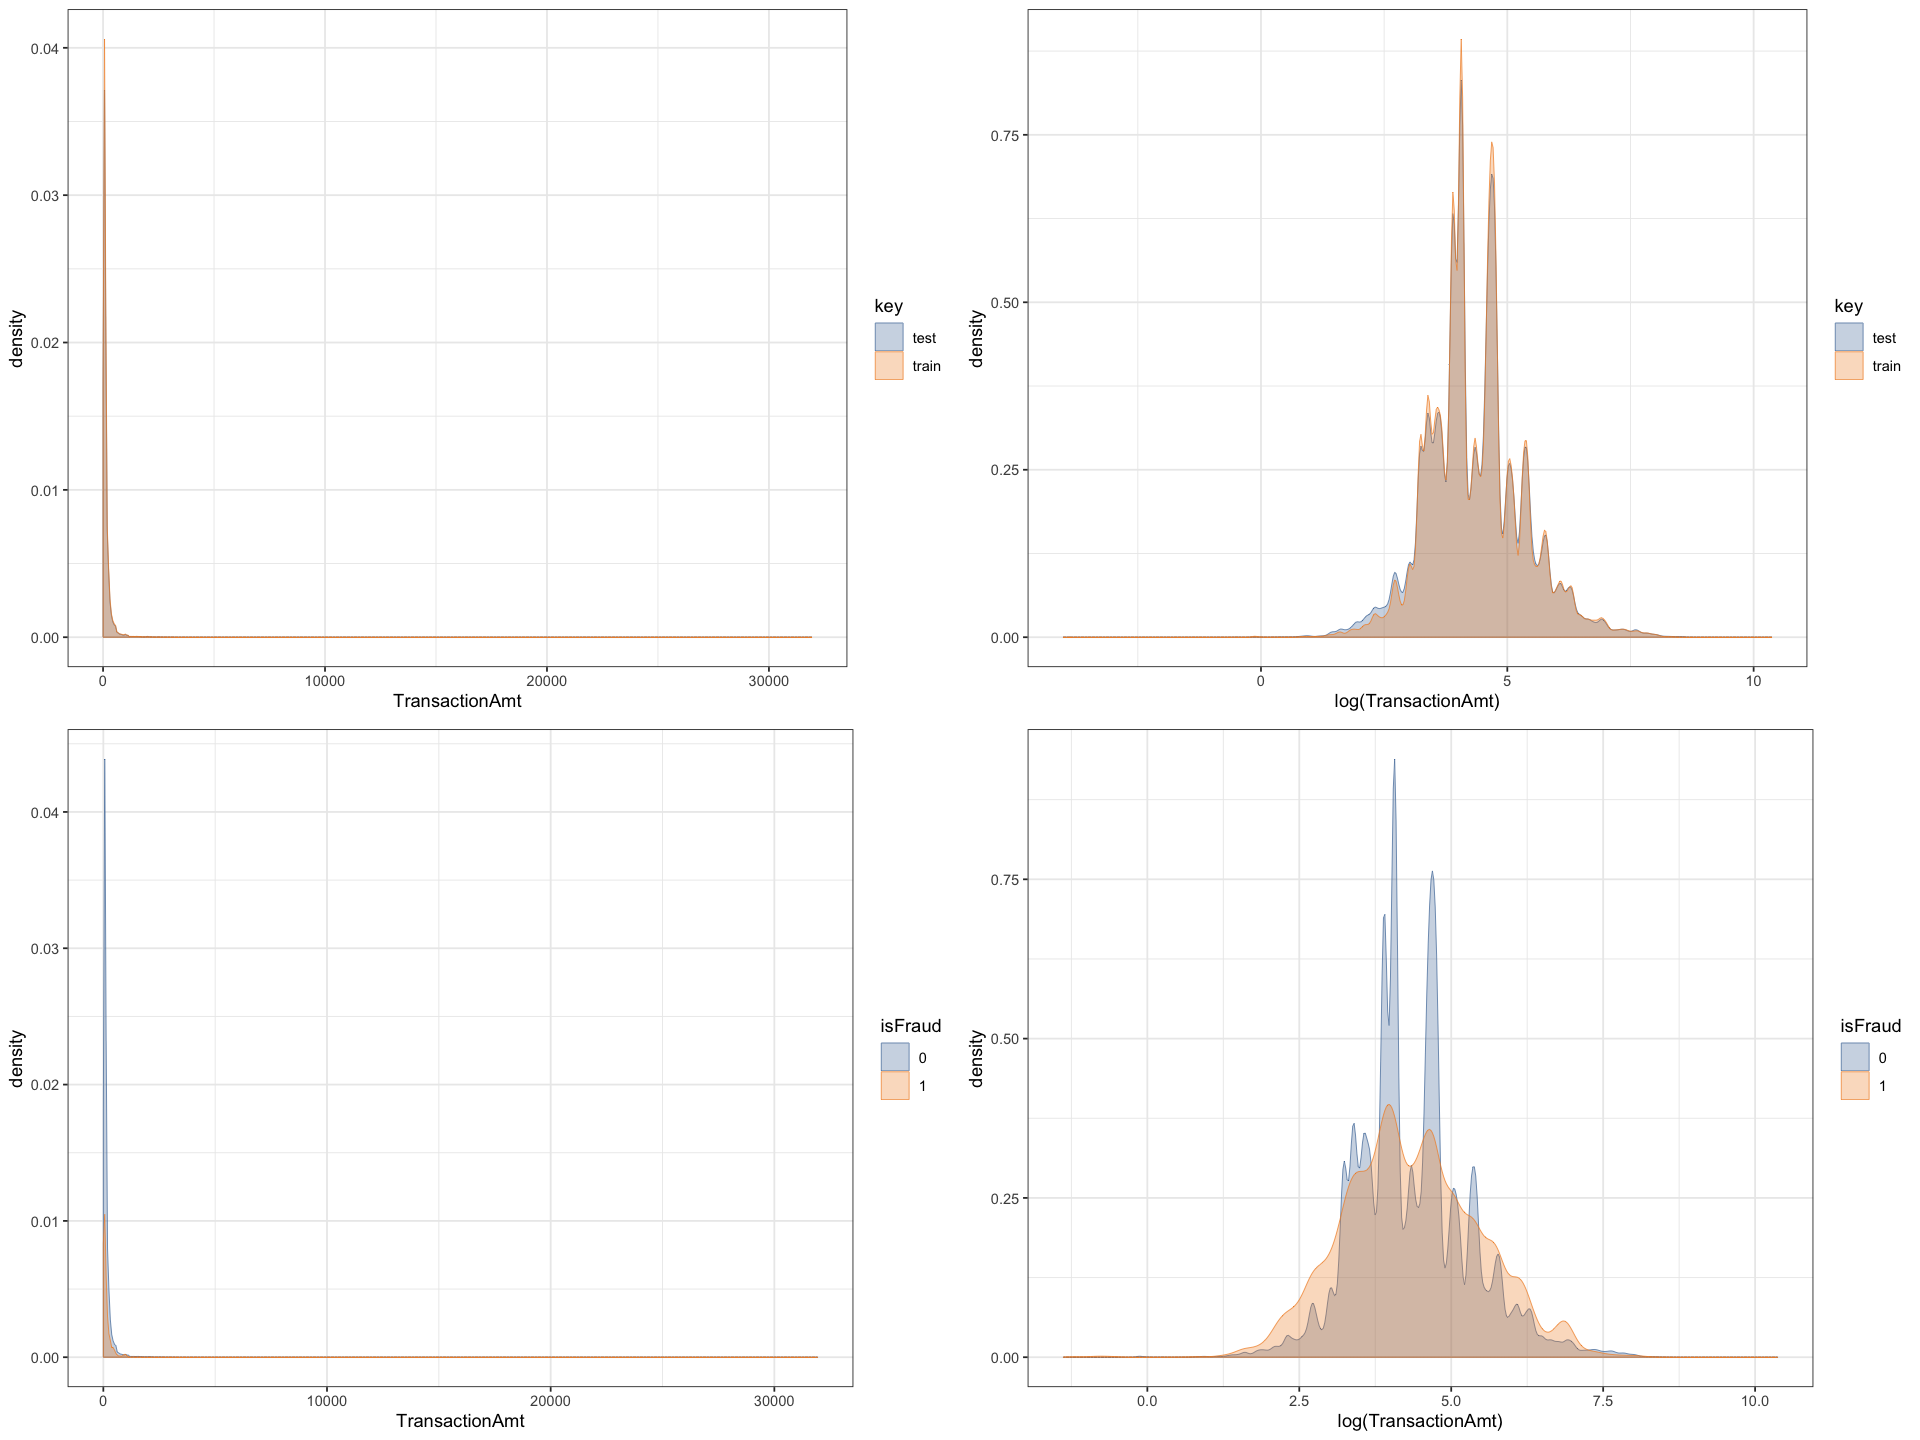

In [56]:
trans_amt_hist <- full %>% 
    ggplot(aes(x= TransactionAmt, fill=key, colour=key)) + 
    geom_density(alpha=0.3, size=0.2) +
    scale_fill_tableau() + 
    scale_color_tableau() + 
    theme_bw()
trans_amt_hist_log <- full %>% 
    ggplot(aes(x= log(TransactionAmt), fill=key, colour=key)) + 
    geom_density(alpha=0.3, size=0.2) +
    scale_fill_tableau() + 
    scale_color_tableau() + 
    theme_bw()
fraud_trans_amt_hist <- train %>% 
    ggplot(aes(x= TransactionAmt, fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.3, size=0.2) +
    scale_fill_tableau() + 
    scale_color_tableau() + 
    theme_bw() + 
    labs(fill='isFraud') + 
    labs(colour='isFraud')
fraud_trans_amt_hist_log <- train %>% 
    ggplot(aes(x= log(TransactionAmt), fill=factor(isFraud), colour=factor(isFraud))) + 
    geom_density(alpha=0.3, size=0.2) +
    scale_fill_tableau() + 
    scale_color_tableau() + 
    theme_bw() + 
    labs(fill='isFraud') + 
    labs(colour='isFraud')
grid.arrange(trans_amt_hist, trans_amt_hist_log, fraud_trans_amt_hist, fraud_trans_amt_hist_log, ncol=2)

In [58]:
str(train)

'data.frame':	590540 obs. of  435 variables:
 $ TransactionID : int  2987000 2987001 2987002 2987003 2987004 2987005 2987006 2987007 2987008 2987009 ...
 $ isFraud       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ TransactionDT : int  86400 86401 86469 86499 86506 86510 86522 86529 86535 86536 ...
 $ TransactionAmt: num  68.5 29 59 50 50 ...
 $ ProductCD     : Factor w/ 5 levels "C","H","R","S",..: 5 5 5 5 2 5 5 5 2 5 ...
 $ card1         : int  13926 2755 4663 18132 4497 5937 12308 12695 2803 17399 ...
 $ card2         : num  NA 404 490 567 514 555 360 490 100 111 ...
 $ card3         : num  150 150 150 150 150 150 150 150 150 150 ...
 $ card4         : Factor w/ 5 levels "","american express",..: 3 4 5 4 4 5 5 5 5 4 ...
 $ card5         : num  142 102 166 117 102 226 166 226 226 224 ...
 $ card6         : Factor w/ 5 levels "","charge card",..: 3 3 4 4 3 4 4 4 4 4 ...
 $ addr1         : num  315 325 330 476 420 272 126 325 337 204 ...
 $ addr2         : num  87 87 87 87 87 87 87 87 87 87 ...
 

In [59]:
summary(train)

 TransactionID        isFraud        TransactionDT      TransactionAmt    
 Min.   :2987000   Min.   :0.00000   Min.   :   86400   Min.   :    0.25  
 1st Qu.:3134635   1st Qu.:0.00000   1st Qu.: 3027058   1st Qu.:   43.32  
 Median :3282270   Median :0.00000   Median : 7306528   Median :   68.77  
 Mean   :3282270   Mean   :0.03499   Mean   : 7372311   Mean   :  135.03  
 3rd Qu.:3429904   3rd Qu.:0.00000   3rd Qu.:11246620   3rd Qu.:  125.00  
 Max.   :3577539   Max.   :1.00000   Max.   :15811131   Max.   :31937.39  
                                                                          
 ProductCD      card1           card2           card3      
 C: 68519   Min.   : 1000   Min.   :100.0   Min.   :100.0  
 H: 33024   1st Qu.: 6019   1st Qu.:214.0   1st Qu.:150.0  
 R: 37699   Median : 9678   Median :361.0   Median :150.0  
 S: 11628   Mean   : 9899   Mean   :362.6   Mean   :153.2  
 W:439670   3rd Qu.:14184   3rd Qu.:512.0   3rd Qu.:150.0  
            Max.   :18396   Max.   :600.

In [ ]:
# # Load the pROC package
# library(pROC)

# # Create a ROC curve
# ROC <- roc(donors$donated, donors$donation_prob)

# # Plot the ROC curve
# plot(ROC, col = 'blue')

# # Calculate the area under the curve (AUC)
# auc(ROC)

# # Find the average age among non-missing values
# summary(donors$age)

# # Impute missing age values with the mean age
# donors$imputed_age <- ifelse(is.na(donors$age), 61.65, donors$age)

# # Create missing value indicator for age
# donors$missing_age <- ifelse(is.na(donors$age), 1, 0)